In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.functions import vector_to_array
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
spark = SparkSession.builder.appName("myapp").master('local[*]').getOrCreate()

24/12/02 16:17:04 WARN Utils: Your hostname, MacBook-Pro-di-Lorenzo-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.166 instead (on interface en0)
24/12/02 16:17:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 16:17:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('dataset/Base.csv', header=True, inferSchema=True)

In [4]:
# Add _encoded to month column
df = df.withColumnRenamed('month', 'month_encoded')

In [5]:
# Creating a list of the categorical features in the dataset
categorical_variables = [col for col in df.columns
                         if isinstance(df.schema[col].dataType, StringType)]

print(categorical_variables)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [6]:
# Step 1: Create StringIndexers for each column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_encoded") for col in categorical_variables]

# Step 2: Create a pipeline with only the indexers
pipeline = Pipeline(stages=indexers)

# Step 3: Fit the pipeline and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Step 4: Select the new index columns, along with other columns if needed
indexed_column_names = [col + "_encoded" for col in categorical_variables]
other_columns = [col for col in df.columns if col not in categorical_variables]  # Get other original columns

df_final = df_encoded.select(*other_columns, *indexed_column_names)

# Show the transformed DataFrame
df_final.show()

24/12/02 16:17:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/12/02 16:17:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_month

In [7]:
#Explicitly filter columns that are IntegerType or DoubleType
numerical_features = [
    col for col in df_final.columns
    if isinstance(df_final.schema[col].dataType, (IntegerType, DoubleType))
]

print("Numerical Features:")
print(numerical_features)

Numerical Features:
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month_encoded', 'payment_type_encoded', 'employment_status_encoded', 'housing_status_encoded', 'source_encoded', 'device_os_encoded']


In [8]:
# Remove from the list all the columns ending with _encoded as they are categorical
numerical_features = [col for col in numerical_features if not col.endswith("_encoded")]

print("Numerical Features (excluding encoded columns):")
print(numerical_features)

Numerical Features (excluding encoded columns):
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count']


In [9]:
#Apply MinMax norm
# Step 2: Assemble these numeric features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_vector")

# Step 3: Apply MinMaxScaler to scale the vector to [0, 1] range
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features_vector")

# Step 4: Apply the assembler and scaler in sequence
df_transformed = assembler.transform(df_final)
df_transformed = scaler.fit(df_transformed).transform(df_transformed)

# Step 5: Convert the scaled vector back into individual columns and overwrite the original columns
df_transformed = df_transformed.withColumn("scaled_features_array", vector_to_array(col("scaled_features_vector")))

# Step 6: Overwrite each original column with its scaled value
for i, feature_name in enumerate(numerical_features):
    df_transformed = df_transformed.withColumn(feature_name, col("scaled_features_array")[i])

# Step 7: Drop intermediate columns to retain only the original set of columns with normalized values
df_transformed = df_transformed.drop("features_vector", "scaled_features_vector", "scaled_features_array")

In [10]:
from pyspark.sql.functions import countDistinct

zero_variance_cols = [
    col_name for col_name in numerical_features
    if df_transformed.select(countDistinct(col_name)).collect()[0][0] <= 1
]

df_transformed = df_transformed.drop(*zero_variance_cols)

In [58]:
df_transformed.show()

+----------+-------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid

# Classification with GBTClassifier and base dataset

In [11]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [12]:
# Rename target_bool column to label
df_transformed = df_transformed.withColumnRenamed("fraud_bool", "label")

In [13]:
# Get a list of the columns in the dataset
columns = df_transformed.columns

# Remove the target column from the list
columns.remove("label")

In [62]:
columns

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'month_encoded',
 'payment_type_encoded',
 'employment_status_encoded',
 'housing_status_encoded',
 'source_encoded',
 'device_os_encoded']

In [23]:
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_transformed)

In [24]:
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns

In [25]:
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

## Training the baseline model

In [66]:
gbt = GBTClassifier(maxIter=10, maxDepth=5, labelCol="label", seed=42,
                    leafCol="LeafId", featuresCol="features")

In [67]:
model = gbt.fit(train_data)

24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_8 in memory! (computed 12.0 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_10 in memory! (computed 12.0 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_1 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_3 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_0 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_9 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_5 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_2 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:15 WARN MemoryStore: Not enough space to cache rdd_342_6 in memory! (computed 7.9 MiB so far)
24/12/01 17:35:1

In [68]:
predictions = model.transform(test_data)

# Show the predictions
predictions.select('features', 'label', 'prediction', 'probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93264397867674...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93294727107968...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93345378823264...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93264397867674...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93310310747216...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93281631827932...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93014696265689...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93247766908780...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93310310747216...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.91423609471675...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.92894477911713...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.92894477911713...|
|(30,[0,1,2,3,4,5,...|  0.0|       0.0|[0.93261877446046...|
|(30,[0,1,2,3,4,5,...|  

In [72]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate accuracy
auc_baseline = evaluator.evaluate(predictions)
print(f"AUC = {auc_baseline:.2f}")

AUC = 0.85


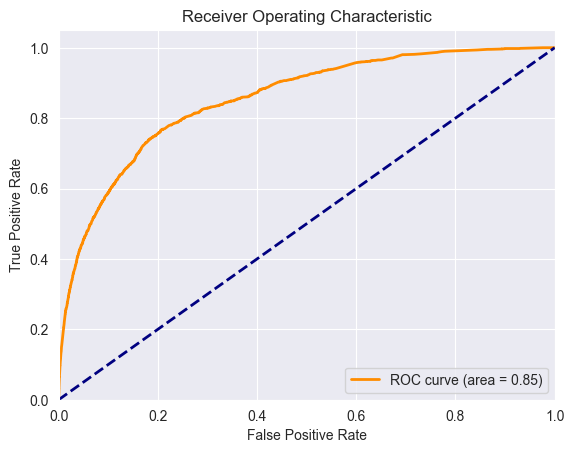

In [74]:
# Convert the DataFrame to a Pandas DataFrame
predictions_pd = predictions.select('label', 'probability').toPandas()

# Get the actual values and the predicted probabilities
y_true = predictions_pd['label']
y_prob = predictions_pd['probability'].apply(lambda x: x[1])

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Compute the area under the ROC curve
roc_auc_baseline = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_baseline:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [75]:
results = predictions.withColumn("prediction", F.col("prediction").cast("double"))

tp = results.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = results.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = results.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = results.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

confusion_matrix = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

print(confusion_matrix)

                 Predicted Negative  Predicted Positive
Actual Negative              197540                   0
Actual Positive                2184                   1


## Using weights to handle class imbalance

In [26]:
total_count = df_transformed.count()
pos_count = df_transformed.filter(col("label") == 1).count()
neg_count = total_count - pos_count

# Compute class weights
pos_weight = total_count / (2.0 * pos_count)
neg_weight = total_count / (2.0 * neg_count)

# Add the weight column to the dataset
df_transformed = df_transformed.withColumn(
    "weight", when(col("label") == 1, pos_weight).otherwise(neg_weight)
)

In [79]:
# Step 2: Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.2, 0.3]) \
    .build()

# Step 3: Set up the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"  # Use AUC as the metric
)

# Step 4: Set up CrossValidator
crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # Use 3-fold cross-validation
    parallelism=2  # Number of threads to use
)

# Step 5: Train the model with cross-validation
cvModel = crossval.fit(train_data)

# Step 6: Extract the best model and parameters
bestModel = cvModel.bestModel
print(f"Best maxDepth: {bestModel.getMaxDepth()}")
print(f"Best maxIter: {bestModel.getMaxIter()}")
print(f"Best stepSize: {bestModel.getStepSize()}")

# Step 7: Evaluate on test data
predictions = bestModel.transform(test_data)
roc_auc = evaluator.evaluate(predictions)
print(f"Test AUC: {roc_auc}")

24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_10 in memory! (computed 5.2 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_7 in memory! (computed 7.9 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_0 in memory! (computed 7.9 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_8 in memory! (computed 7.9 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_2 in memory! (computed 12.0 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_9 in memory! (computed 12.0 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_4 in memory! (computed 5.2 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_3 in memory! (computed 5.2 MiB so far)
24/12/01 19:16:52 WARN MemoryStore: Not enough space to cache rdd_39929_6 in memory! (computed 7.9 MiB so far

Best maxDepth: 3
Best maxIter: 30
Best stepSize: 0.3


Test AUC: 0.8915258792993638


In [27]:
# Get a list of the columns in the dataset
columns = df_transformed.columns

# Remove the target column and weight column from the list of feature columns
columns.remove("label")
columns.remove("weight")

# Assemble features
assembler = VectorAssembler(inputCols=columns, outputCol="features")
data_transformed = assembler.transform(df_transformed)

# Prepare the final dataset
dataset = data_transformed.select("features", "label", "weight")  # Include 'weight' column

# Split into training and testing datasets
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

# Train GBTClassifier with weights
gbt = GBTClassifier(featuresCol="features", labelCol="label", weightCol="weight", maxIter=30, maxDepth=3, stepSize=0.3, seed=42)
model = gbt.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Weighted AUC: {auc}")

24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_3 in memory! (computed 7.9 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_2 in memory! (computed 7.9 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_8 in memory! (computed 7.9 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_11 in memory! (computed 5.2 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_4 in memory! (computed 5.2 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_6 in memory! (computed 5.2 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_9 in memory! (computed 5.2 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_7 in memory! (computed 5.2 MiB so far)
24/12/02 14:12:39 WARN MemoryStore: Not enough space to cache rdd_677_10 in memory! (computed 7.9 MiB so far)
24/12/02 14:12:39

Weighted AUC: 0.8909504479468165


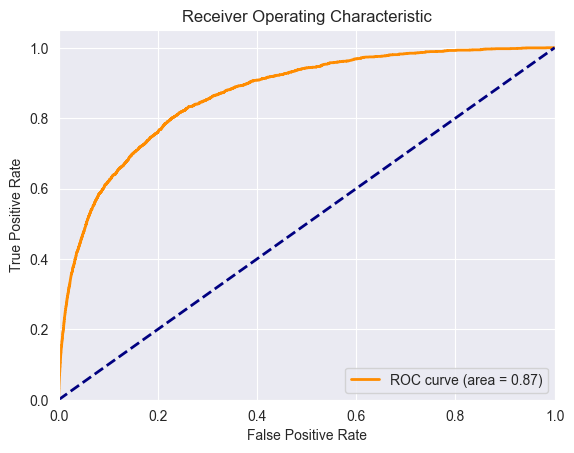

In [32]:
# Print the ROC curve
predictions_pd = predictions.select("label", "probability").toPandas()

# Get the actual values and the predicted probabilities
y_true = predictions_pd["label"]
y_prob = predictions_pd["probability"].apply(lambda x: x[1])

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Compute the area under the ROC curve
roc_auc_weighted = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_weighted:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [28]:
from pyspark.sql import functions as F
results = predictions.withColumn("prediction", F.col("prediction").cast("double"))

tp = results.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = results.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = results.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = results.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


confusion_matrix = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

print(confusion_matrix)

                 Predicted Negative  Predicted Positive
Actual Negative              161761               35779
Actual Positive                 433                1752


## Training model with random undersampling

In [14]:
# Under-sampling the majority class
majority_class = df_transformed.filter(df_transformed['label'] == 0)
minority_class = df_transformed.filter(df_transformed['label'] == 1)

# Setting the seed for reproducibility
seed = 42
# Downsample the majority class
majority_downsampled = majority_class.sample(False, minority_class.count() / majority_class.count(), seed)

# Combine the downsampled majority class with the minority class
df_undersampled = majority_downsampled.union(minority_class)

# Show the number of fraud and non-fraud transactions
df_undersampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|11129|
|  1.0|11029|
+-----+-----+


In [15]:
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_undersampled)

In [16]:
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns

In [17]:
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

In [ ]:
gbt = GBTClassifier(maxIter=10, maxDepth=5, labelCol="label", seed=42,
                    leafCol="LeafId", featuresCol="features")